In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#!/usr/bin/env python3
"""
ppm (P3) を読み，RGB値を 0.00-1.00 に正規化して
Python のリスト形式で出力 & 可能ならクリップボードへコピーするスクリプト
"""

def read_p3_ppm(path):
    tokens = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            # コメント(#)以降を取り除き，残りのトークンを追加
            line = line.split('#', 1)[0].strip()
            if not line:
                continue
            tokens.extend(line.split())

    if len(tokens) < 4:
        raise ValueError("ppmファイルの形式が正しくありません")

    if tokens[0] != 'P3':
        raise ValueError("P3形式のppmを指定してください")

    # ヘッダを読み取る
    idx = 1
    # 幅と高さ
    width = int(tokens[idx]); idx += 1
    height = int(tokens[idx]); idx += 1
    maxval = int(tokens[idx]); idx += 1

    expected_values = width * height * 3
    remaining = tokens[idx:]
    if len(remaining) < expected_values:
        raise ValueError(f"ピクセルデータが不足しています（期待 {expected_values} 個，見つかった {len(remaining)} 個）")

    # ピクセルを読み取り，0-1に正規化（小数点2桁に丸め）
    pixels = []
    for i in range(0, expected_values, 3):
        r = int(remaining[i])
        g = int(remaining[i+1])
        b = int(remaining[i+2])
        pixels.append([round(r / maxval, 2), round(g / maxval, 2), round(b / maxval, 2)])

    return pixels, width, height

def format_as_python_list(pixels, width, height):
    """ 見やすく各行ごとに出力するリスト表記を作る """
    lines = []
    lines.append('[')
    for row in range(height):
        row_pixels = pixels[row*width:(row+1)*width]
        # 各画素を [x.xx, y.yy, z.zz] の形で並べる
        pixel_strs = [f"[{p[0]:.2f}, {p[1]:.2f}, {p[2]:.2f}]" for p in row_pixels]
        lines.append('    ' + ', '.join(pixel_strs) + (',' if row != height-1 else ''))
    lines.append(']')
    return '\n'.join(lines)

def copy_to_clipboard(text):
    """ pyperclip があればそれを使い，なければ tkinter を試す """
    try:
        import pyperclip
        pyperclip.copy(text)
        return True
    except Exception:
        try:
            # tkinter を使う方法（環境によってはXサーバ/GUIが必要）
            import tkinter as tk
            r = tk.Tk()
            r.withdraw()
            r.clipboard_clear()
            r.clipboard_append(text)
            r.update()  # クリップボードに渡す
            r.destroy()
            return True
        except Exception:
            return False

def main():
    path = input("読み込む ppm（P3）ファイル名を入力してください：").strip()
    try:
        pixels, w, h = read_p3_ppm(path)
    except Exception as e:
        print("エラー：", e)
        return

    out_text = format_as_python_list(pixels, w, h)
    print("\n出力（コピー可能な形式）．\n")
    print(out_text)

    if copy_to_clipboard(out_text):
        print("\nクリップボードにコピーしました．")
    else:
        print("\nクリップボードにコピーできませんでした．必要なら出力を選択してコピーしてください．")

if __name__ == '__main__':
    main()

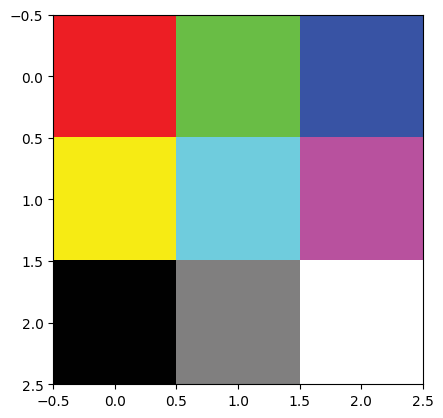

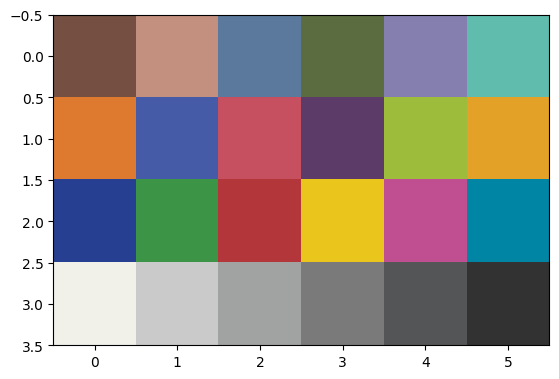

In [3]:
# 推論データ
X =  np.array([
    [0.63, 0.12, 0.07], [0.24, 0.88, 0.22], [0.07, 0.28, 0.40],
    [0.88, 0.99, 0.28], [0.40, 0.98, 0.91], [0.56, 0.20, 0.27],
    [0.00, 0.00, 0.00], [0.28, 0.53, 0.36], [0.97, 1.00, 0.99],

    [0.22, 0.13, 0.06], [0.65, 0.64, 0.36], [0.15, 0.43, 0.42], [0.15, 0.37, 0.10], [0.34, 0.55, 0.55], [0.28, 0.96, 0.68],
    [0.68, 0.38, 0.08], [0.02, 0.25, 0.37], [0.60, 0.14, 0.11], [0.11, 0.05, 0.10], [0.49, 0.97, 0.22], [0.76, 0.74, 0.16],
    [0.01, 0.08, 0.18], [0.08, 0.59, 0.16], [0.49, 0.09, 0.03], [0.83, 0.97, 0.23], [0.59, 0.16, 0.19], [0.09, 0.57, 0.57],
    [1.00, 1.00, 1.00], [0.68, 0.97, 0.74], [0.44, 0.71, 0.49], [0.25, 0.45, 0.30], [0.11, 0.17, 0.13], [0.00, 0.03, 0.01],
    ], dtype=np.float32)

img1 = cv2.resize(cv2.imread("img/reference_image1_cmyk_large.png", cv2.IMREAD_COLOR_RGB), (3,3), interpolation=cv2.INTER_NEAREST)
img2 = cv2.resize(cv2.imread("img/reference_image2_cmyk_large.png", cv2.IMREAD_COLOR_RGB), (6,4), interpolation=cv2.INTER_NEAREST)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

# 正解データ
Y = np.concatenate([img1.reshape([-1, 3])/255, img2.reshape([-1, 3])/255], axis=0).astype(np.float32)

In [3]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# モデル定義
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 60),
            nn.ReLU(),
            nn.Linear(60, 60),
            nn.ReLU(),
            nn.Linear(60, 3),
        )

    def forward(self, x):
        return self.model(x)

model = ColorNet()

# 損失関数（MSE）
criterion = nn.MSELoss()

# 最適化手法
optimizer = optim.Adam(model.parameters(), lr=0.01)

# L1正則化の係数 (重みを0を多くなるように定義している)
lambda_l1 = 1e-6

# 学習ループ
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(X_tensor)
    mse = criterion(outputs, Y_tensor)

    # --- L1 正則化-----------------------------
    l1 = torch.tensor(0.0, requires_grad=False)
    for name, p in model.named_parameters():
        if 'weight' in name:
            l1 = l1 + p.abs().sum()
    loss = mse + lambda_l1 * l1
    # -----------------------------------------

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{epochs}]  MSE: {mse.item():.6f}  L1: {l1.item():.2f}  Loss: {loss.item():.6f}')

threshold = 0.01 # しきい値の設定

with torch.no_grad():
    predictions = model(X_tensor)
    print("\n予測結果：")
    print(predictions.numpy())

    
# C++ 用の配列形式に変換する関数
def convert_to_cpp_array(tensor: torch.Tensor, name: str, dtype: str = "float",threshold:float=0.01):
    # Tensor → numpy 配列
    flat = tensor.detach().numpy().flatten()
    
    # しきい値以下の値を0にする
    # where(条件, 条件がTrueのときの値, 条件がFalseのときの値)
    flat = np.where(np.abs(flat) < threshold, 0, flat)
    
    array_str = f"{dtype} {name}[] = {{"
    array_str += ", ".join(map(str, flat))
    array_str += "};"
    return array_str



# C++ 用のパラメータファイルを作成
cpp_code = ""

layer_idx = 1
for layer in model.model:
    if isinstance(layer, torch.nn.Linear):
        cpp_code += convert_to_cpp_array(layer.weight, f"weight_{layer_idx}") + "\n"
        cpp_code += convert_to_cpp_array(layer.bias,   f"bias_{layer_idx}") + "\n"
        layer_idx += 1

with open("model_parameters.h", "w") as f:
    f.write(cpp_code)

print("\nC++ 用のパラメータファイル (model_parameters.h) を作成しました。")


Epoch [0/50000]  MSE: 0.445629  L1: 292.13  Loss: 0.445921
Epoch [500/50000]  MSE: 0.000908  L1: 224.78  Loss: 0.001133
Epoch [1000/50000]  MSE: 0.000228  L1: 221.57  Loss: 0.000450
Epoch [1500/50000]  MSE: 0.000101  L1: 206.70  Loss: 0.000308
Epoch [2000/50000]  MSE: 0.000205  L1: 196.10  Loss: 0.000401
Epoch [2500/50000]  MSE: 0.000168  L1: 183.65  Loss: 0.000351
Epoch [3000/50000]  MSE: 0.000044  L1: 170.92  Loss: 0.000215
Epoch [3500/50000]  MSE: 0.000013  L1: 158.59  Loss: 0.000171
Epoch [4000/50000]  MSE: 0.000054  L1: 148.35  Loss: 0.000202
Epoch [4500/50000]  MSE: 0.000025  L1: 140.91  Loss: 0.000166
Epoch [5000/50000]  MSE: 0.000008  L1: 132.55  Loss: 0.000141
Epoch [5500/50000]  MSE: 0.000013  L1: 127.50  Loss: 0.000141
Epoch [6000/50000]  MSE: 0.000029  L1: 121.78  Loss: 0.000150
Epoch [6500/50000]  MSE: 0.000287  L1: 117.49  Loss: 0.000404
Epoch [7000/50000]  MSE: 0.000009  L1: 113.55  Loss: 0.000122
Epoch [7500/50000]  MSE: 0.000004  L1: 109.55  Loss: 0.000113
Epoch [8000/

In [5]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# モデル定義
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 120),
            nn.ReLU(),
            nn.Linear(120, 120),
            nn.ReLU(),
            nn.Linear(120, 3),
        )

    def forward(self, x):
        return self.model(x)

model = ColorNet()

# 損失関数（MSE）
criterion = nn.MSELoss()

# 最適化手法
optimizer = optim.Adam(model.parameters(), lr=0.01)

# L1正則化の係数 (重みを0を多くなるように定義している)
lambda_l1 = 1e-6

# 学習ループ
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(X_tensor)
    mse = criterion(outputs, Y_tensor)

    # --- L1 正則化-----------------------------
    l1 = torch.tensor(0.0, requires_grad=False)
    for name, p in model.named_parameters():
        if 'weight' in name:
            l1 = l1 + p.abs().sum()
    loss = mse + lambda_l1 * l1
    # -----------------------------------------

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{epochs}]  MSE: {mse.item():.6f}  L1: {l1.item():.2f}  Loss: {loss.item():.6f}')

threshold = 0.01 # しきい値の設定

with torch.no_grad():
    predictions = model(X_tensor)
    print("\n予測結果：")
    print(predictions.numpy())

    
# C++ 用の配列形式に変換する関数
def convert_to_cpp_array(tensor: torch.Tensor, name: str, dtype: str = "float",threshold:float=0.01):
    # Tensor → numpy 配列
    flat = tensor.detach().numpy().flatten()
    
    # しきい値以下の値を0にする
    # where(条件, 条件がTrueのときの値, 条件がFalseのときの値)
    flat = np.where(np.abs(flat) < threshold, 0, flat)
    
    array_str = f"{dtype} {name}[] = {{"
    array_str += ", ".join(map(str, flat))
    array_str += "};"
    return array_str



# C++ 用のパラメータファイルを作成
cpp_code = ""

layer_idx = 1
for layer in model.model:
    if isinstance(layer, torch.nn.Linear):
        cpp_code += convert_to_cpp_array(layer.weight, f"weight_{layer_idx}") + "\n"
        cpp_code += convert_to_cpp_array(layer.bias,   f"bias_{layer_idx}") + "\n"
        layer_idx += 1

with open("model_parameters.h", "w") as f:
    f.write(cpp_code)

print("\nC++ 用のパラメータファイル (model_parameters.h) を作成しました。")


Epoch [0/50000]  MSE: 0.335274  L1: 775.85  Loss: 0.336050
Epoch [500/50000]  MSE: 0.000225  L1: 529.02  Loss: 0.000755
Epoch [1000/50000]  MSE: 0.000078  L1: 407.68  Loss: 0.000486
Epoch [1500/50000]  MSE: 0.000066  L1: 324.46  Loss: 0.000390
Epoch [2000/50000]  MSE: 0.000029  L1: 267.70  Loss: 0.000297
Epoch [2500/50000]  MSE: 0.000007  L1: 231.92  Loss: 0.000239
Epoch [3000/50000]  MSE: 0.000047  L1: 205.36  Loss: 0.000252
Epoch [3500/50000]  MSE: 0.000007  L1: 185.16  Loss: 0.000192
Epoch [4000/50000]  MSE: 0.000073  L1: 175.05  Loss: 0.000248
Epoch [4500/50000]  MSE: 0.000044  L1: 169.39  Loss: 0.000213
Epoch [5000/50000]  MSE: 0.000029  L1: 157.50  Loss: 0.000187
Epoch [5500/50000]  MSE: 0.000023  L1: 146.83  Loss: 0.000170
Epoch [6000/50000]  MSE: 0.000008  L1: 137.92  Loss: 0.000146
Epoch [6500/50000]  MSE: 0.000011  L1: 130.85  Loss: 0.000141
Epoch [7000/50000]  MSE: 0.000023  L1: 125.55  Loss: 0.000148
Epoch [7500/50000]  MSE: 0.000045  L1: 122.23  Loss: 0.000167
Epoch [8000/

In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix

# --- CSR形式への変換関数 ---
def convert_to_csr_arrays(tensor: torch.Tensor, name: str, threshold: float = 0.01):
    """
    PyTorchテンソルをCSR形式に変換し、C++用配列文字列として返す
    """
    arr = tensor.detach().numpy()
    arr = np.where(np.abs(arr) < threshold, 0, arr)

    csr = csr_matrix(arr)

    # CSRの主要3配列をC++配列として出力
    data_str = f"float {name}_data[] = {{ " + ", ".join(map(str, csr.data)) + " };"
    indices_str = f"int {name}_indices[] = {{ " + ", ".join(map(str, csr.indices)) + " };"
    indptr_str = f"int {name}_indptr[] = {{ " + ", ".join(map(str, csr.indptr)) + " };"

    shape_str = f"int {name}_shape[2] = {{{csr.shape[0]}, {csr.shape[1]}}};"

    return "\n".join([data_str, indices_str, indptr_str, shape_str])


# --- Dense配列（biasなど）用 ---
def convert_to_dense_array(tensor: torch.Tensor, name: str, dtype: str = "float", threshold: float = 0.01):
    flat = tensor.detach().numpy().flatten()
    flat = np.where(np.abs(flat) < threshold, 0, flat)
    array_str = f"{dtype} {name}[] = {{ " + ", ".join(map(str, flat)) + " };"
    return array_str


# --- C++コード生成部分 ---
cpp_code = ""

layer_idx = 1
for layer in model.model:
    if isinstance(layer, torch.nn.Linear):
        cpp_code += f"// Layer {layer_idx}\n"
        cpp_code += convert_to_csr_arrays(layer.weight, f"weight_{layer_idx}") + "\n"
        cpp_code += convert_to_dense_array(layer.bias, f"bias_{layer_idx}") + "\n\n"
        layer_idx += 1

with open("model_parameters_csr_1.h", "w") as f:
    f.write(cpp_code)

print("\nC++ 用のCSRパラメータファイル (model_parameters_csr.h) を作成しました。")



C++ 用のCSRパラメータファイル (model_parameters_csr.h) を作成しました。
